To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?
2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.
3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'studentsperformance'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from studentsperformance',con=engine)
engine.dispose()

In [3]:
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

ANS: after boxcox, the distribution became more normal, which are indicated by Jarque-Bera, normal test's p-value. (p-value increased)
note that: boxcox need to work on positive values, while there are 1 zero score in math score variables. I discarded the records in order to perform boxcox transform.

math score Jarque-Bera: (15.912256686712709, 0.0003505075386818213)
math score normal test: NormaltestResult(statistic=15.408960513931822, pvalue=0.00045080293869937836)
---------
reading score Jarque-Bera: (11.383300575987892, 0.0033740202672214448)
reading score normal test: NormaltestResult(statistic=11.11741279628622, pvalue=0.003853758403576582)
---------
writing score Jarque-Bera: (13.98509448257235, 0.0009187033894586527)
writing score normal test: NormaltestResult(statistic=13.606450837263859, pvalue=0.0011101885439899974)
---------
math score Jarque-Bera after boxcox: (1.7200982636836308, 0.42314129209599327)
math score normal test after boxcox: NormaltestResult(statistic=1.8323075851586939, pvalue=0.4000547794685686)
---------
reading score Jarque-Bera after boxcox: (4.8891540799411395, 0.08676282434883942)
reading score normal test after boxcox: NormaltestResult(statistic=6.546500254297637, pvalue=0.03788310187455936)
---------
writing score Jarque-Bera after boxcox: (5.7623

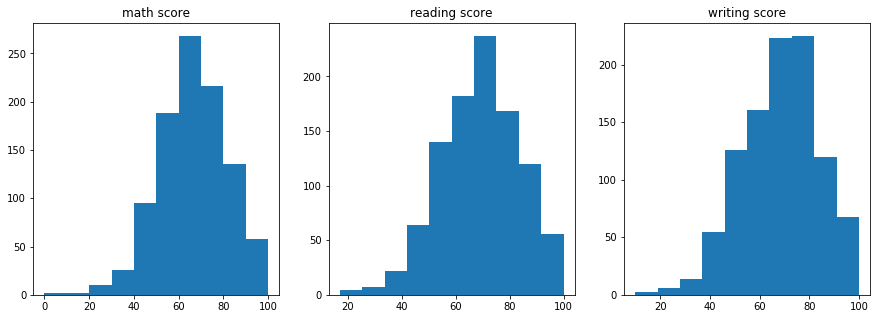

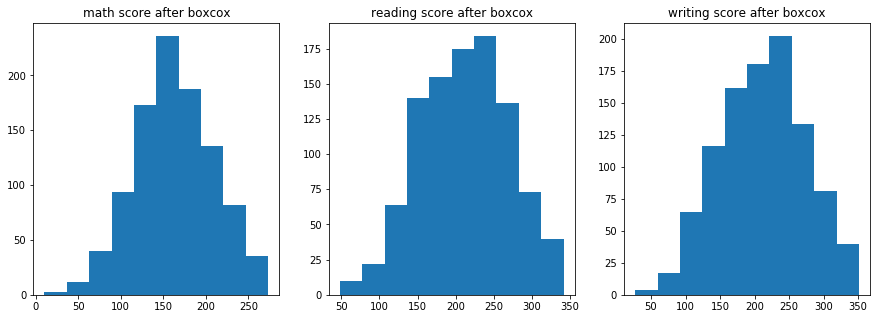

In [4]:
# check normaility before boxcox 
plt.figure(figsize=(15,5))

score_list = ['math score', 'reading score', 'writing score']
for score,index in zip(score_list, range(len(score_list))):
    plt.subplot(1, len(score_list), index+1)
    plt.hist(df[score])
    plt.title(score)
    print("{} Jarque-Bera: {}".format(score, stats.jarque_bera(df[score])))
    print("{} normal test: {}".format(score, stats.normaltest(df[score])))
    print('---------')

    
# check normaility after boxcox 
plt.figure(figsize=(15,5))

score_list = ['math score', 'reading score', 'writing score']
df_boxcox = df[df['math score']!=0].copy()
# df_boxcox.info()
# df_boxcox['math score'],_ = stats.boxcox(df_boxcox['math score'])
for score,index in zip(score_list, range(len(score_list))):
    df_boxcox[score],_ = stats.boxcox(df_boxcox[score])

for score,index in zip(score_list, range(len(score_list))):
    plt.subplot(1, len(score_list), index+1)
    plt.hist(df_boxcox[score])
    plt.title(score + ' after boxcox')
    print("{} Jarque-Bera after boxcox: {}".format(score, stats.jarque_bera(df_boxcox[score])))
    print("{} normal test after boxcox: {}".format(score, stats.normaltest(df_boxcox[score])))
    print('---------')

2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

ANS: first we create a new column called score_average, which take average of the math, reading and writing score. The histogram show that the distribution is normal-like, but not enough. The Jarque-Bera test as well as normal test confirm the results
Then, we perform coxbox transform on the score_average data. As the histogram show, the distribution became more normal-like. Also the P-value increased in the normal test. So, we can say that the boxcox transformation helped to improve formality in this case.

score_average Jarque-Bera: (15.453387913085168, 0.00044089934264401887)
score_average normal test: NormaltestResult(statistic=15.186721327231322, pvalue=0.0005037851534494478)
---------


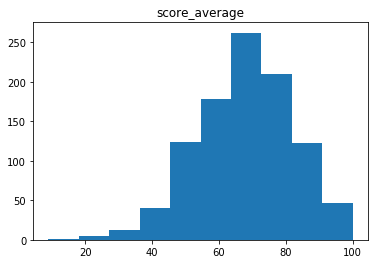

score_average after boxcox Jarque-Bera: (2.4353989331279173, 0.29591013563984203)
score_average after boxcox normal test: NormaltestResult(statistic=2.779857602227616, pvalue=0.24909303914726724)
---------


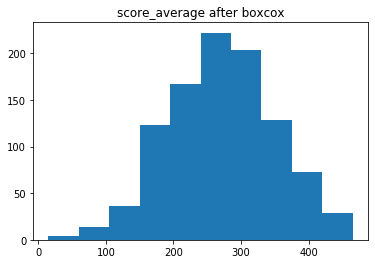

In [8]:
# create a new variable as average
df['score_average'] =  (df[score_list[0]] + df[score_list[1]] + df[score_list[2]]) / 3
df.describe()

plt.hist(df['score_average'])
plt.title('score_average')
print("{} Jarque-Bera: {}".format('score_average', stats.jarque_bera(df['score_average'])))
print("{} normal test: {}".format('score_average', stats.normaltest(df['score_average'])))
print('---------')
plt.show()


# perform boxcox
score_average_boxcox, _ = stats.boxcox(df['score_average'])

plt.hist(score_average_boxcox)
plt.title('score_average after boxcox')
print("{} Jarque-Bera: {}".format('score_average after boxcox', stats.jarque_bera(score_average_boxcox)))
print("{} normal test: {}".format('score_average after boxcox', stats.normaltest(score_average_boxcox)))
print('---------')
plt.show()

3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

ANS: start with visulization method, using scatter plot. From that we can see, all three have high correlation with the target varialbe, while writting and reading are slightly higher. 
To confirm that we continued to calculate the correlation coefficient using stats.personr. The result showed that reading-average has the highest correlation coefficient of 0.97.

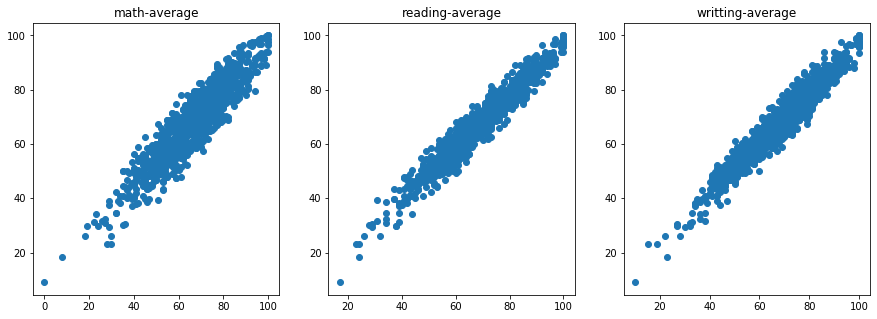

math score-average   , correlation coefficient: 0.9187457588383448, p-value: 0.0. 
reading score-average , correlation coefficient: 0.9703306887176952, p-value: 0.0. 
writing score-average , correlation coefficient: 0.965667237454207, p-value: 0.0. 


In [9]:
# let's check correlation between math-average, writting-average, and reading-average. 
# first, let's visulize correlation using scatter plot
score_list = ['math score', 'reading score', 'writing score', 'score_average']

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df[score_list[0]], df[score_list[3]])
plt.title('math-average')

plt.subplot(1,3,2)
plt.scatter(df[score_list[1]], df[score_list[3]])
plt.title('reading-average')

plt.subplot(1,3,3)
plt.scatter(df[score_list[2]], df[score_list[3]])
plt.title('writting-average')
plt.show()

# it looks like reading and writting are both highly correlated with average score. Let's confirm that with despritive stats.
for index in range(len(score_list)-1):
    cc, p_value = stats.pearsonr(df[score_list[index]], df[score_list[3]])
    print("{:20s} , correlation coefficient: {}, p-value: {}. ".format(score_list[index] + '-average', cc, p_value)) 

# discussion boxcox gives very different result, when the two samples only have one variable difference

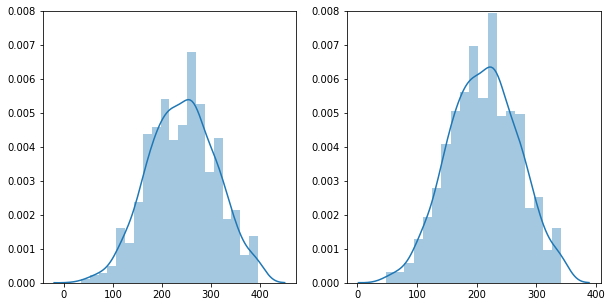

1000
999


In [38]:
# check normaility after boxcox 

# this sample has size of 1000
plt.figure(figsize=(10,5))
df_reading,_ = stats.boxcox(df['reading score'])
plt.subplot(1,2,1)
# plt.hist(df_reading, bins=20)
sns.distplot(df_reading)
# plt.ylim(0,150)
plt.ylim(0,0.008)
# print(df_reading)
# plt.show()

# this sample eliminate one item from the former sample, it has sample size of 999, everything else is the same.
df_reading2,_ = stats.boxcox(df[df['math score']> 0]['reading score'])
plt.subplot(1,2,2)
# plt.hist(df_reading2, bins=20)
sns.distplot(df_reading2)
# plt.ylim(0,150)
plt.ylim(0,0.008)
# print(df_reading2)
plt.show()




print(len(df_reading))
print(len(df_reading2))

# takeaways
- even a single item differnt can make it totally different when using boxcox transformation. I don't know why it happened and what would be the consequence. To me, it seems the transformation result is not very consistent.

- I didn't get the idea of question 3. My answer is totally different from the example solution. I think I can find more answers in PCA.